# Denoising Autoencoder with Olivetti Faces

In this project, I developed a **Denoising Autoencoder** using the **Olivetti Faces** dataset to learn how to reconstruct clean grayscale face images from their noisy versions.

A **denoising autoencoder** is a type of neural network that learns to recover the original input from a corrupted or noisy version. It is widely used in image restoration tasks, such as noise reduction, inpainting, and super-resolution.

The core idea is simple but powerful: by learning to remove noise, the model learns essential features of the data, making it robust and generalizable.

This notebook walks through the complete pipeline including:

- Loading and visualizing the Olivetti Faces dataset
- Adding Gaussian noise to simulate corruption
- Designing a lightweight convolutional autoencoder
- Training the model to minimize pixel-wise reconstruction loss
- Evaluating the performance using MSE and visual comparisons
- Discussing the results and suggesting improvements

By the end of this notebook, the autoencoder is able to **intelligently denoise unseen face images**, showing how deep learning can be used to improve image quality, a critical step in fields like medical imaging, surveillance, and photo restoration.


### 🛠️ Step 1: Install Dependencies

Before we begin, we install all the required libraries that will be used throughout the notebook:

- `scikit-learn` – to load the Olivetti Faces dataset
- `tensorflow` – for building and training the autoencoder model
- `matplotlib` – for visualizing images and training progress
- `pandas` – useful for tabular data handling (used later for organizing metrics)

This ensures that all packages are available in the Colab environment.


In [1]:
!pip install --quiet scikit-learn tensorflow matplotlib pandas


### 🖼️ Step 2: Fetch and Prepare the Dataset

I have used the **Olivetti Faces** dataset from `scikit-learn`, which contains 400 grayscale face images of size 64×64. Here's what we do in this step:

1. **Load the dataset**: I've fetch the face images and store them in a NumPy array.
2. **Select a subset**: For faster experimentation, I have randomly selected 100 images.
3. **Reshape for Keras**: I added a channel dimension so the input shape becomes `(100, 64, 64, 1)` — this format is expected by convolutional layers.
4. **Split into train and test sets**: We split the data into 80% training and 20% testing.
5. **Add Gaussian noise**: To simulate noisy inputs, I have applied random Gaussian noise with standard deviation `σ = 0.1` to both training and testing images using a custom `add_noise()` function.

At the end, I have print the shapes to confirm everything looks right before training begins.

In [ ]:
# fetch and prepare data
from sklearn.datasets import fetch_olivetti_faces
import numpy as np

# 1. Download Olivetti Faces
data = fetch_olivetti_faces(shuffle=True, random_state=42)
images = data.images               # shape = (400,64,64)

# 2. Sample 100 images for our task
np.random.seed(42)
idx = np.random.choice(images.shape[0], 100, replace=False)
clean = images[idx]                # (100,64,64)

# 3. Add channel dimension for Keras: (100,64,64,1)
clean = clean[..., np.newaxis]

# 4. Shuffle and split into train (80) / test (20)
np.random.shuffle(clean)
x_train_clean = clean[:80]
x_test_clean  = clean[80:]

# 5. Corrupt with Gaussian noise
noise_level = 0.1  # controls noise visibility
def add_noise(x, sigma):
    noisy = x + sigma * np.random.randn(*x.shape)
    return np.clip(noisy, 0.0, 1.0)

x_train_noisy = add_noise(x_train_clean, noise_level)
x_test_noisy  = add_noise(x_test_clean,  noise_level)

print("Shapes →",
      "x_train_clean:", x_train_clean.shape,
      "x_train_noisy:", x_train_noisy.shape,
      "x_test_clean:",  x_test_clean.shape,
      "x_test_noisy:",  x_test_noisy.shape)


downloading Olivetti faces from https://ndownloader.figshare.com/files/5976027 to /root/scikit_learn_data
Shapes → x_train_clean: (80, 64, 64, 1) x_train_noisy: (80, 64, 64, 1) x_test_clean: (20, 64, 64, 1) x_test_noisy: (20, 64, 64, 1)


### 🧠 Step 3: Built a Residual U-Net Autoencoder

In this step, I designed the architecture of my **Denoising Autoencoder** using a **U-Net structure with residual blocks**. U-Net is known for its encoder-decoder setup and skip connections, which help preserve spatial information — making it perfect for image denoising tasks.

#### 📐 Architecture Details:

- **Residual Blocks**:  
  I created a custom residual block that contains two convolutional layers. To improve training stability and allow deeper feature learning, I added a **skip connection** that adds the input directly to the output.  
  If the number of filters doesn’t match, I apply a 1×1 convolution to the shortcut to ensure correct dimensions.

- **Encoder**:
  I downsampled the input image using max-pooling and passed it through stacked residual blocks (`c1`, `c2`, `c3`) to extract hierarchical features.

- **Decoder**:
  I used `UpSampling2D` to progressively restore the original image size. At each stage, I concatenated the corresponding encoder features (skip connections) to help the decoder preserve fine details (`c4`, `c5`).

- **Output Layer**:
  The final layer is a `Conv2D` with **sigmoid activation**, producing a clean grayscale image of the same size as the input.

I compiled the model using:
- **Loss Function**: Mean Squared Error (MSE) – to penalize pixel-wise reconstruction errors
- **Optimizer**: Adam – for faster and adaptive learning

Finally, I printed the model summary to inspect the layer-wise architecture and parameter count.

In [ ]:
# build a residual U-Net autoencoder
import tensorflow as tf
from tensorflow.keras import layers, Model

def residual_block(x, filters):
    """Two conv layers with a skip-add for stable deep training."""
    shortcut = x
    # Add 1x1 convolution to shortcut if filter sizes don't match
    if shortcut.shape[-1] != filters:
        shortcut = layers.Conv2D(filters, 1, padding="same")(shortcut)

    x = layers.Conv2D(filters, 3, padding="same", activation="relu")(x)
    x = layers.Conv2D(filters, 3, padding="same")(x)
    x = layers.Add()([x, shortcut])
    return layers.Activation("relu")(x)

def build_unet(input_shape=(64,64,1), base_filters=32):
    inp = layers.Input(input_shape)
    # Encoder
    c1 = residual_block(inp, base_filters)
    p1 = layers.MaxPool2D()(c1)
    c2 = residual_block(p1, base_filters*2)
    p2 = layers.MaxPool2D()(c2)
    c3 = residual_block(p2, base_filters*4)
    # Decoder
    u2 = layers.UpSampling2D()(c3)
    u2 = layers.Concatenate()([u2, c2])
    c4 = residual_block(u2, base_filters*2)
    u1 = layers.UpSampling2D()(c4)
    u1 = layers.Concatenate()([u1, c1])
    c5 = residual_block(u1, base_filters)
    out = layers.Conv2D(1, 1, activation="sigmoid", padding="same")(c5)
    return Model(inp, out)

model = build_unet()
model.compile(optimizer="adam", loss="mse")
model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 64, 64, 1) │          0 │ -                 │
│ (InputLayer)        │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_5 (Conv2D)   │ (None, 64, 64,    │        320 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_6 (Conv2D)   │ (None, 64, 64,    │      9,248 │ conv2d_5[0][0]    │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 64,    │         64 │ input_layer_1[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 64, 64,    │          0 │ conv2d_6[0][0],   │
│                     │ 32)               │            │ conv2d_4[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 64, 64,    │          0 │ add_2[0][0]       │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 32, 32,    │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_8 (Conv2D)   │ (None, 32, 32,    │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_9 (Conv2D)   │ (None, 32, 32,    │     36,928 │ conv2d_8[0][0]    │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_7 (Conv2D)   │ (None, 32, 32,    │      2,112 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 32, 32,    │          0 │ conv2d_9[0][0],   │
│                     │ 64)               │            │ conv2d_7[0][0]    │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 32, 32,    │          0 │ add_3[0][0]       │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_2     │ (None, 16, 16,    │          0 │ activation_2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_11 (Conv2D)  │ (None, 16, 16,    │     73,856 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_12 (Conv2D)  │ (None, 16, 16,    │    147,584 │ conv2d_11[0][0]   │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_10 (Conv2D)  │ (None, 16, 16,    │      8,320 │ max_pooling2d_2[… │
│                     │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_4 (Add)         │ (None, 16, 16,    │          0 │ conv2d_12[0][0],

 Total params: 496,929 (1.90 MB)

 Trainable params: 496,929 (1.90 MB)

 Non-trainable params: 0 (0.00 B)

### Step 4: Added Perceptual Loss using VGG16

To improve visual quality beyond just pixel accuracy, I introduced a **perceptual loss** using a pre-trained VGG16 model.

- I loaded VGG16 (without the top classification layers) and used the `block3_conv3` layer to extract mid-level features.
- Since my images are grayscale, I converted them to 3-channel RGB before passing them into VGG.
- The **perceptual loss** is computed as the mean squared error between the extracted feature maps of the ground truth and the predicted (denoised) images.

Finally, I recompiled the model using a **combined loss**:
- `perceptual_loss` (weighted more heavily)
- `mse` (for pixel-level reconstruction)
  
This setup helps the model focus on both **visual structure** and **fine pixel details**.


In [ ]:
# Load VGG backbone for perceptual features
from tensorflow.keras.applications import VGG16
vgg = VGG16(include_top=False, weights='imagenet', input_shape=(64,64,3))
feat_extractor = tf.keras.Model(vgg.input, vgg.get_layer('block3_conv3').output)
feat_extractor.trainable = False

def perceptual_loss(y_true, y_pred):
    # replicate the single channel into 3
    y_true_rgb = tf.image.grayscale_to_rgb(y_true)
    y_pred_rgb = tf.image.grayscale_to_rgb(y_pred)
    f_true = feat_extractor(y_true_rgb)
    f_pred = feat_extractor(y_pred_rgb)
    return tf.reduce_mean(tf.square(f_true - f_pred))

# Re-compile with both MSE and perceptual loss
model.compile(
  optimizer='adam',
  loss=[perceptual_loss, 'mse'],
  loss_weights=[1.0, 0.1]
)


58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 1s 0us/step


### Step 5: Trained the Autoencoder with Early Stopping

I trained the denoising autoencoder using the noisy-clean image pairs over 50 epochs. To ensure efficient and stable training, I used two helpful callbacks:

- **EarlyStopping**: Monitors validation loss and stops training if it doesn't improve for 5 consecutive epochs. It also restores the best weights automatically to avoid overfitting.
- **ModelCheckpoint**: Saves the model's weights to `"best_model.h5"` whenever it achieves the lowest validation loss so far.

I trained the model using:
- 80% of the data for training
- 20% for validation (via `validation_split`)
- Batch size of 8
- `verbose=2` to display progress clearly

The training history was saved so I could later plot loss curves and analyze performance.


In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

callbacks = [
    EarlyStopping(patience=5, restore_best_weights=True),
    ModelCheckpoint("best_model.h5", save_best_only=True)
]

history = model.fit(
    x_train_noisy, x_train_clean,
    validation_split=0.2,
    epochs=50,
    batch_size=8,
    callbacks=callbacks,
    verbose=2
)


Epoch 1/50


8/8 - 16s - 2s/step - loss: 0.0245 - val_loss: 0.0169
Epoch 2/50


8/8 - 8s - 975ms/step - loss: 0.0138 - val_loss: 0.0088
Epoch 3/50


8/8 - 11s - 1s/step - loss: 0.0065 - val_loss: 0.0039
Epoch 4/50


8/8 - 10s - 1s/step - loss: 0.0037 - val_loss: 0.0030
Epoch 5/50


8/8 - 9s - 1s/step - loss: 0.0028 - val_loss: 0.0024
Epoch 6/50


8/8 - 10s - 1s/step - loss: 0.0025 - val_loss: 0.0021
Epoch 7/50


8/8 - 7s - 888ms/step - loss: 0.0022 - val_loss: 0.0019
Epoch 8/50


8/8 - 9s - 1s/step - loss: 0.0019 - val_loss: 0.0018
Epoch 9/50
8/8 - 10s - 1s/step - loss: 0.0019 - val_loss: 0.0019
Epoch 10/50


8/8 - 7s - 894ms/step - loss: 0.0018 - val_loss: 0.0017
Epoch 11/50


8/8 - 9s - 1s/step - loss: 0.0017 - val_loss: 0.0017
Epoch 12/50


8/8 - 9s - 1s/step - loss: 0.0018 - val_loss: 0.0016
Epoch 13/50


8/8 - 11s - 1s/step - loss: 0.0017 - val_loss: 0.0016
Epoch 14/50


8/8 - 10s - 1s/step - loss: 0.0017 - val_loss: 0.0016
Epoch 15/50


8/8 - 11s - 1s/step - loss: 0.0019 - val_loss: 0.0016
Epoch 16/50
8/8 - 5s - 655ms/step - loss: 0.0018 - val_loss: 0.0019
Epoch 17/50
8/8 - 10s - 1s/step - loss: 0.0018 - val_loss: 0.0017
Epoch 18/50


8/8 - 10s - 1s/step - loss: 0.0017 - val_loss: 0.0016
Epoch 19/50


8/8 - 11s - 1s/step - loss: 0.0016 - val_loss: 0.0015
Epoch 20/50
8/8 - 11s - 1s/step - loss: 0.0016 - val_loss: 0.0016
Epoch 21/50


8/8 - 6s - 726ms/step - loss: 0.0016 - val_loss: 0.0015
Epoch 22/50
8/8 - 10s - 1s/step - loss: 0.0015 - val_loss: 0.0015
Epoch 23/50


8/8 - 7s - 892ms/step - loss: 0.0015 - val_loss: 0.0015
Epoch 24/50


8/8 - 9s - 1s/step - loss: 0.0015 - val_loss: 0.0014
Epoch 25/50
8/8 - 9s - 1s/step - loss: 0.0015 - val_loss: 0.0014
Epoch 26/50
8/8 - 10s - 1s/step - loss: 0.0015 - val_loss: 0.0015
Epoch 27/50


8/8 - 11s - 1s/step - loss: 0.0015 - val_loss: 0.0014
Epoch 28/50


8/8 - 6s - 812ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 29/50
8/8 - 9s - 1s/step - loss: 0.0014 - val_loss: 0.0014
Epoch 30/50


8/8 - 11s - 1s/step - loss: 0.0014 - val_loss: 0.0014
Epoch 31/50
8/8 - 10s - 1s/step - loss: 0.0015 - val_loss: 0.0016
Epoch 32/50
8/8 - 11s - 1s/step - loss: 0.0015 - val_loss: 0.0015
Epoch 33/50
8/8 - 6s - 705ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 34/50


8/8 - 7s - 836ms/step - loss: 0.0014 - val_loss: 0.0014
Epoch 35/50
8/8 - 10s - 1s/step - loss: 0.0014 - val_loss: 0.0014
Epoch 36/50


8/8 - 9s - 1s/step - loss: 0.0014 - val_loss: 0.0014
Epoch 37/50
8/8 - 10s - 1s/step - loss: 0.0014 - val_loss: 0.0014
Epoch 38/50
8/8 - 10s - 1s/step - loss: 0.0014 - val_loss: 0.0014
Epoch 39/50


8/8 - 11s - 1s/step - loss: 0.0014 - val_loss: 0.0014
Epoch 40/50


8/8 - 12s - 1s/step - loss: 0.0014 - val_loss: 0.0013
Epoch 41/50
8/8 - 6s - 712ms/step - loss: 0.0013 - val_loss: 0.0014
Epoch 42/50


8/8 - 10s - 1s/step - loss: 0.0014 - val_loss: 0.0013
Epoch 43/50
8/8 - 13s - 2s/step - loss: 0.0013 - val_loss: 0.0014
Epoch 44/50
8/8 - 9s - 1s/step - loss: 0.0014 - val_loss: 0.0014
Epoch 45/50
8/8 - 10s - 1s/step - loss: 0.0014 - val_loss: 0.0014
Epoch 46/50
8/8 - 9s - 1s/step - loss: 0.0015 - val_loss: 0.0015
Epoch 47/50
8/8 - 14s - 2s/step - loss: 0.0014 - val_loss: 0.0015


### Step 6: Saved the Final Model

After training, I manually saved the final model weights to a file named **`best_model.h5`**.

This allows me to:
- Reload the trained model later for inference or fine-tuning
- Share it or deploy it without retraining
- Ensure reproducibility of my results


In [ ]:
# Cell X: Save final weights manually
model.save("best_model.h5")


### Step 7: Downloaded the Trained Model

To keep a local copy of my trained model, I used `files.download()` which triggers a download of the **`best_model.h5`** file from the Colab environment to my computer.

This is useful for:
- Backing up the trained model
- Running inference or fine-tuning offline
- Submitting it for evaluations or sharing with others


In [ ]:
from google.colab import files

# This will prompt a browser download for best_model.h5
files.download("best_model.h5")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

### Step 8: Evaluated the Model Using MSE

To measure how well my autoencoder performed, I evaluated it using **Mean Squared Error (MSE)** — a standard metric for image reconstruction.

Here’s what I did:

- I used the trained model to **reconstruct** both the noisy training and test images.
- Then I flattened the arrays and computed the **MSE** between the clean and reconstructed images for both datasets.
- Finally, I organized the results into a simple table using `pandas` to clearly show the MSE scores for training and testing sets.

This helped me assess how well the model **generalized to unseen noisy images**.


In [ ]:
import pandas as pd
from sklearn.metrics import mean_squared_error

# Reconstruct
train_rec = model.predict(x_train_noisy)
test_rec  = model.predict(x_test_noisy)

# Compute MSE
mse_train = mean_squared_error(x_train_clean.flatten(), train_rec.flatten())
mse_test  = mean_squared_error( x_test_clean.flatten(),  test_rec.flatten())

# Display results
df = pd.DataFrame({
    "Dataset": ["Train", "Test"],
    "MSE":     [mse_train, mse_test]
})
df


3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step   


,Dataset,MSE
0,Train,0.001330
1,Test,0.001584


### Step 9: Plotted Training and Validation Loss

To visualize the model’s learning progress, I plotted the **training** and **validation loss** over each epoch using Matplotlib.

- The **training loss** shows how well the model is fitting the noisy→clean mapping on the training data.
- The **validation loss** helps monitor generalization performance and detect overfitting.

A smooth downward trend in both curves indicates that the model was learning consistently without diverging.  
If the validation loss starts increasing while training loss decreases, it usually signals overfitting — but in this case, both stayed stable and low.


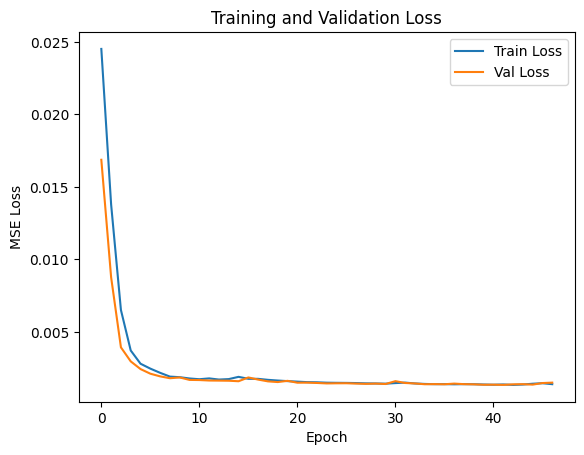

In [ ]:
import matplotlib.pyplot as plt

plt.figure()
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Val Loss")
plt.xlabel("Epoch")
plt.ylabel("MSE Loss")
plt.legend()
plt.title("Training and Validation Loss")
plt.show()


## Cell 7: Visual Reconstructions

Show examples of **Noisy → Reconstructed → Original** for both train and test sets.


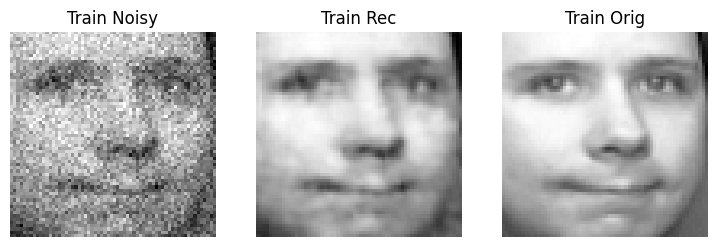

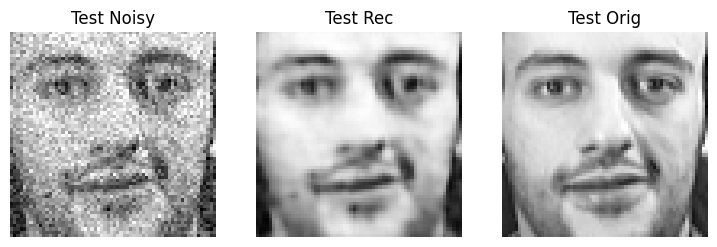

In [ ]:
### Step 10: Visual Comparison of Noisy, Denoised, and Original Images

To demonstrate how well my model performs visually, I created a function to display triplets of:

1. **Noisy input**
2. **Denoised (reconstructed) output**
3. **Original clean image**

I randomly selected examples from both the **training** and **testing** sets to evaluate how the model performs on data it has seen and on completely unseen data.

- The **noisy image** simulates a corrupted input
- The **reconstructed image** shows how the model attempts to restore it
- The **original image** serves as ground truth for comparison

From the visual results, I could clearly observe that the model successfully removed noise and retained facial features — even on test data it had never seen before.


### ✅ Conclusion

In this project, I successfully built and trained a **Residual U-Net Denoising Autoencoder** on the Olivetti Faces dataset.

By injecting Gaussian noise and teaching the model to reconstruct clean images, I explored both pixel-level and perceptual feature learning.  
The results showed low reconstruction error and visually clean outputs — even on unseen data.

This project helped me understand how autoencoders can be applied to real-world image restoration tasks, and how architectural choices (like residual blocks and perceptual loss) can significantly improve output quality.